In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime

matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

## <font color='steelblue'>Going over the lifelines package</font>

### <font color='steelblue'>Kaplan-Meier and Nelson-Aalen</font>

Let's start by importing some data. We need the durations that individuals are observed for, and whether they "died" or not.

In [3]:
from lifelines.datasets import load_waltons
df = load_waltons() # returns a Pandas DataFrame

print(df.head())

      T  E    group
0   6.0  1  miR-137
1  13.0  1  miR-137
2  13.0  1  miR-137
3  13.0  1  miR-137
4  19.0  1  miR-137


In [5]:
T = df['T']
E = df['E']

```T``` is an array of durations, ```E``` is either boolean or binary array representing whether the "death" was observed (alternatively an individual can be censored).

### Note

By default, _lifelines_ assumes all "deaths" are obsersved ( == 1)

In [7]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E) # more succiently, kmf.fit(T,E)

<lifelines.KaplanMeierFitter: fitted with 163 observations, 7 censored>

After calling the ```fit``` method, we have access to new properties like ```survival_function_``` and methods like ```plot()```. The latter is a wrapper around Pandas internal plotting library.

* ```kmf.survival_function_```
* ```kmf.median_```
* ```kmf.plot()```

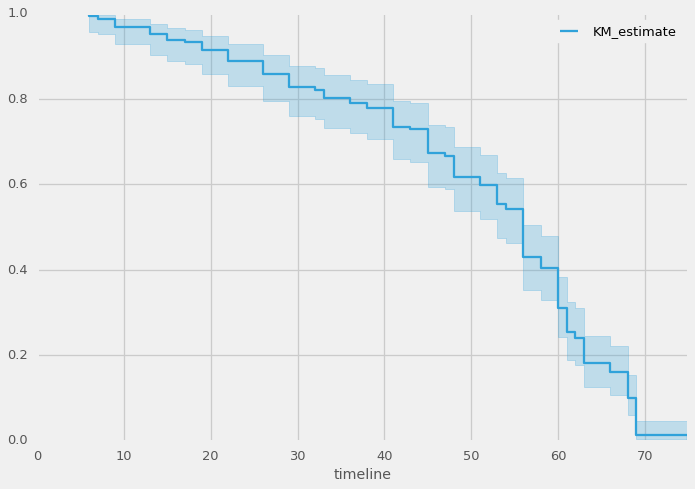

In [9]:
kmf.plot();

## Multiple groups

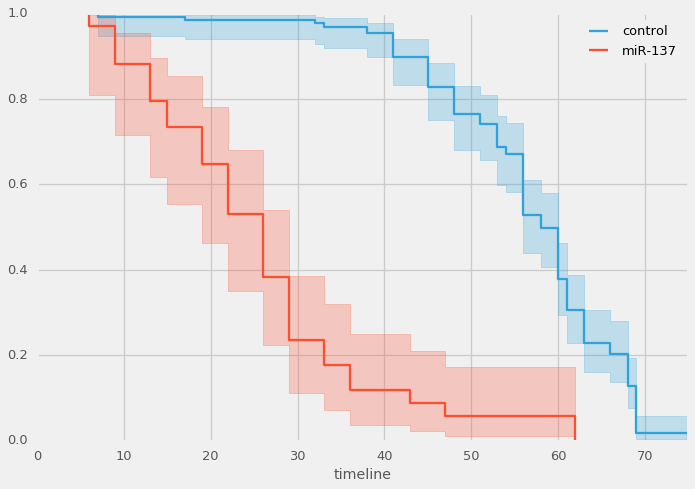

In [11]:
groups = df['group']
ix = (groups == 'miR-137')

kmf.fit(T[~ix], E[~ix], label='control')
ax = kmf.plot()

kmf2 = KaplanMeierFitter()

kmf2.fit(T[ix], E[ix], label='miR-137')
kmf2.plot(ax=ax)

Similar functionality exists for the ```NelsonAalenFitter```:

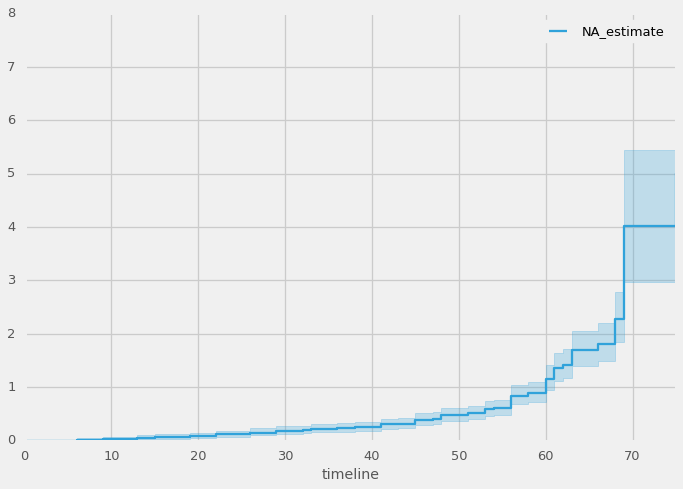

In [12]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(T, event_observed=E)
naf.plot()

but instead of a ```survival_function_``` being exposed, a ```cumulative_hazard_``` is

Perhaps you are interested in viewing the survival table given some durations and censorship vectors:

In [14]:
from lifelines.utils import survival_table_from_events

table = survival_table_from_events(T, E)
print(table.head())


          removed  observed  censored  entrance  at_risk
event_at                                                
0.0           0.0       0.0       0.0     163.0    163.0
6.0           1.0       1.0       0.0       0.0    163.0
7.0           2.0       1.0       1.0       0.0    162.0
9.0           3.0       3.0       0.0       0.0    160.0
13.0          3.0       3.0       0.0       0.0    157.0


## <font color='steelblue'>Survival Regression</font>

While the above ```KaplanMeierFitter``` and ```NelsonAalenFitter``` are useful, they only give us an "average" view of the population. Often we hvae specific data at the individual level, either continuous or categorical, that we would like to use. For this, we turn to **survival regression**, specifically ```AalenAdditiveFitter``` or ```CoxPHFitter```.

In [15]:
from lifelines.datasets import load_regression_dataset
regression_dataset = load_regression_dataset()

regression_dataset.head()


,var1,var2,var3,T,E
0,0.595170,1.143472,1.571079,14.785479,1
1,0.209325,0.184677,0.356980,7.336734,1
2,0.693919,0.071893,0.557960,5.271527,1
3,0.443804,1.364646,0.374221,11.684168,1
4,1.613324,0.125566,1.921325,7.637764,1


The input of the ```fit``` method's API on ```AalenAdditiveFitter``` is different than above. All the data, including duratoins, censorships and covariates must be contained in a **Pandas Dataframe** (yes, it must be a DataFrame). The duration column and event column must be specified in the call to ```fit```:

In [16]:
from lifelines import AalenAdditiveFitter, CoxPHFitter

# Using Cox Proportional Hazards model
cf = CoxPHFitter()
cf.fit(regression_dataset, 'T', event_col='E')
cf.print_summary()

# Using Aalen's Additive model
aaf = AalenAdditiveFitter(fit_intercept=False)
aaf.fit(regression_dataset, 'T', event_col='E')

n=200, number of events=189

          coef  exp(coef)  se(coef)         z         p  lower 0.95  upper 0.95    
var1 2.084e-01  1.232e+00 6.991e-02 2.981e+00 2.876e-03   7.134e-02   3.455e-01  **
var2 4.601e-02  1.047e+00 7.507e-02 6.129e-01 5.400e-01  -1.012e-01   1.932e-01    
var3 2.110e-01  1.235e+00 7.314e-02 2.885e+00 3.913e-03   6.764e-02   3.544e-01  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.580
 [-----------------100%-----------------] 189 of 189 complete in 0.1 sec


<lifelines.AalenAdditiveFitter: fitted with 200 observations, 11 censored>

After fitting, you'll have access to properties like ```cumulative_hazards_``` and methods like ```plot```, ```predict_cumulative_hazards```, and ```predict_survival_function```. The latter two methods require an additional argument of individual covarites:

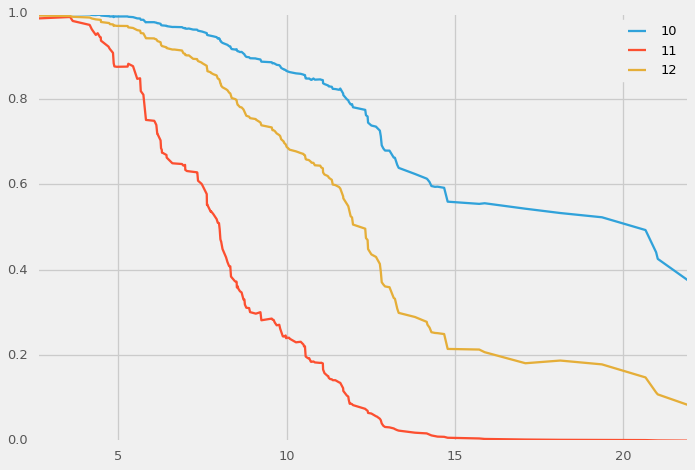

In [23]:
x = regression_dataset[list(set(regression_dataset.columns).difference(set(['E','T'])))]
aaf.predict_survival_function(x.ix[10:12]).plot(); #get the unique survival functions of the first two subjects

Like the above estimators, there is also a built-in plotting method:

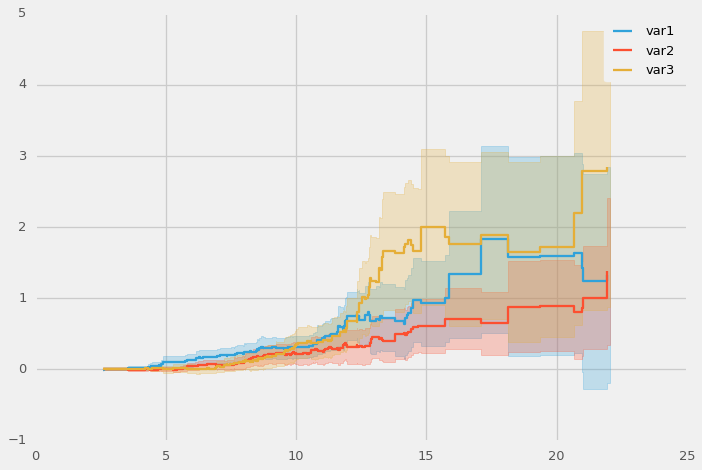

In [24]:
aaf.plot()

## Introduction to Survival Analysis

## <font color='steelblue'>

Traditionally, survival analysis was developed to measure lifespans of individuals. An actuary or health professional would ask questions like "how long does this population live for", and answer it using survival analysis. For example, the population may be nation's population (for actuaries), or a population stricken by disease (in the medical professional's case). Traditionally, sort of a morbid subject.

The analysis can be further applied to not just traditional _births and deaths_, but any duration. Medical professionals might be interest in the _time between childbirths_, where a birth in this is case is the event of having a child, and a death is becmoing pregnant again! (obviously, we are loose with our definitions of _birth and death_). Another example is users surbscribing to a serice: a birth is a user who joins the service, and a death is when the user leaves the service.

## Censorship

At the time you wanto make inferences about durations, it is possible, likely true, that not all the death events have occured yet. For example, a medical professional will not wait 50 years for each individual in the study to pass awy before investigating - he or she is interested in the effectiveness of improving lifetimes after only a few years, or months possibly.

The individuals in a population who have not been subject to the death event are labeled as _right-censored_, i.e. we did not (or can not) view the rest of their life history due to some external circumstances. All the information we have on these individuals are their current lifetime durations (which is naturally _less_ than their actual lifetimes).

### Note
There is also left-censorship, where an individual's birth event is not seen.

A common mistake data analysts make is choosing to ignore the right-censored individuals. We shall see why this is a mistake next:

Consider a case where the population is actually made up of two subpopulations, **A** and **B**. Population **A** has a very small lifespan, say 2 months on average, and population **B** enjoys a much longer lifespan, say 12 months on average. We might not know this distinction beforehand. At $t=10$, we wish to investigate the average lifespan. Below is an example of such a situation.

In [46]:
from lifelines.plotting import plot_lifetimes
from numpy.random import uniform, exponential

N = 50
current_time = 10
actual_lifetimes = np.array([[exponential(12), exponential(2)][uniform()<.5] for i in range(N)])
observed_lifetimes = np.minimum(actual_lifetimes, current_time)

actual_lifetimes

array([  0.90153171,   1.82929367,   1.14990159,   0.0723314 ,
         4.49601624,   1.95814127,   3.55670187,   2.95179251,
         0.47883773,   1.44016553,   8.77754373,   9.6357427 ,
         5.09064296,   2.16593182,   1.85211899,   4.27794085,
         2.18130514,   0.83070499,   3.60920617,   1.15878373,
        13.59318222,   1.01871507,  18.18335893,   4.80952538,
         1.60524303,  23.52471121,   8.50929853,  10.09952914,
         0.63692465,  22.7292296 ,   2.87611565,   7.78139268,
        35.42296117,   1.62549135,   0.71552094,   0.86043382,
         6.50448902,   5.60630798,  12.21941648,  20.6449199 ,
        37.4252185 ,   8.40130647,  15.5125464 ,   4.51376083,
         2.06758302,   1.92880172,   0.15942355,   0.04574174,
         2.76525963,   1.62669757])

In [47]:
observed_lifetimes

array([  0.90153171,   1.82929367,   1.14990159,   0.0723314 ,
         4.49601624,   1.95814127,   3.55670187,   2.95179251,
         0.47883773,   1.44016553,   8.77754373,   9.6357427 ,
         5.09064296,   2.16593182,   1.85211899,   4.27794085,
         2.18130514,   0.83070499,   3.60920617,   1.15878373,
        10.        ,   1.01871507,  10.        ,   4.80952538,
         1.60524303,  10.        ,   8.50929853,  10.        ,
         0.63692465,  10.        ,   2.87611565,   7.78139268,
        10.        ,   1.62549135,   0.71552094,   0.86043382,
         6.50448902,   5.60630798,  10.        ,  10.        ,
        10.        ,   8.40130647,  10.        ,   4.51376083,
         2.06758302,   1.92880172,   0.15942355,   0.04574174,
         2.76525963,   1.62669757])

In [48]:
observed = actual_lifetimes < current_time

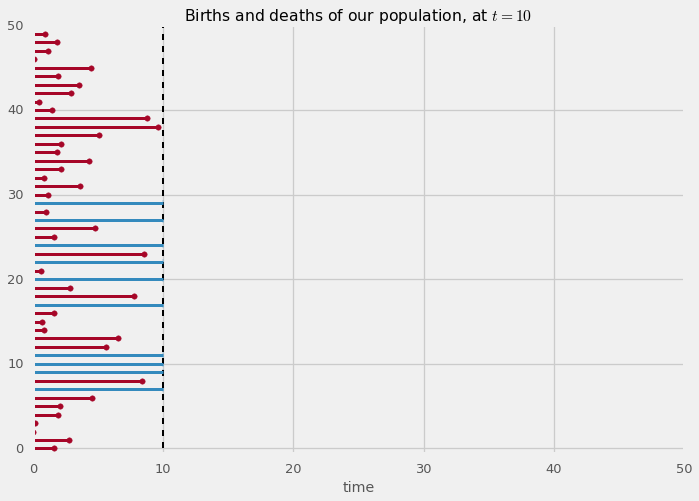

Observed lifetimes at time 10:
 [  0.90153171   1.82929367   1.14990159   0.0723314    4.49601624
   1.95814127   3.55670187   2.95179251   0.47883773   1.44016553
   8.77754373   9.6357427    5.09064296   2.16593182   1.85211899
   4.27794085   2.18130514   0.83070499   3.60920617   1.15878373  10.
   1.01871507  10.           4.80952538   1.60524303  10.           8.50929853
  10.           0.63692465  10.           2.87611565   7.78139268  10.
   1.62549135   0.71552094   0.86043382   6.50448902   5.60630798  10.          10.
  10.           8.40130647  10.           4.51376083   2.06758302
   1.92880172   0.15942355   0.04574174   2.76525963   1.62669757]


In [53]:
plt.xlim(0,50)
plt.vlines(10,0,55,lw=2, linestyles="--")
plt.xlabel('time')
plt.title('Births and deaths of our population, at $t=10$')
plot_lifetimes(observed_lifetimes, event_observed=observed)
print("Observed lifetimes at time %d:\n"%(current_time), observed_lifetimes)

The red lines denote the lifespan of individuals where the death event has been observed, and the blue lines denote the lifespan of the right-censored individuals (deaths have not been observed). If we are asked to estimate the average lifetime of our population, and we natively decided to _not_ include the right-censored individuals, it is cledar that we would be severely underestimating the true averge lifespan.

Furthermore, if we instead simply took the mean of _all_ observed lifespans, including the current lifespans of right-censored instances, we would _still_ be underestimating the true averge lifespan. Below we plot the actual lifetimes of all instances (recall we do not see this information at $t = 10$):

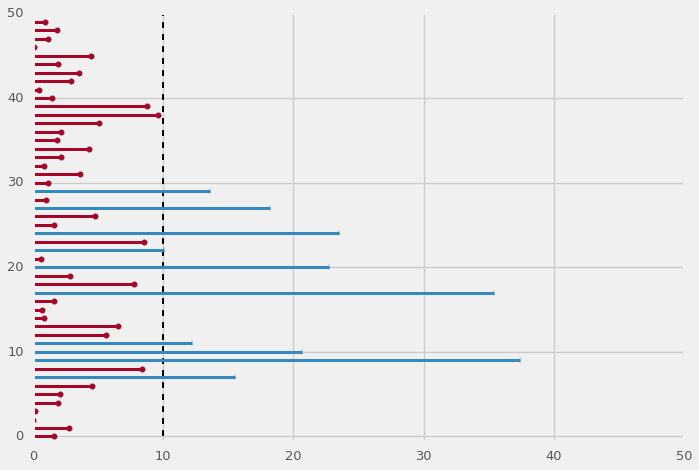

In [54]:
plt.xlim(0,50)
plt.vlines(10,0,55,lw=2,linestyles="--")
plot_lifetimes(actual_lifetimes, event_observed=observed);

Survival analysis was originally developed to solve this type of problem, that is, to deal with estimation when our data is right-censored. Even in the case where all events have been observed, i.e. no censorship, survival analysis is still very useful for understanding durations.

The observations need not always start at zero, either. This was done only for understanding in the above example. Consider the example of a customer entering a store a birth: a customer can enter at any time, and not necessarily at time zero. In survival analysis, durations are relative: individuals may start at different times. (We actually only need the _duration_ of the observation, and not necessarily the start and end times).

We next introduce the two fundamental objects in survival analysis, the _survival function_ and the _hazard function_.

## Survival function

Let $T$ be a (possibly infinite, but always non-negative) random lifetime taken from the population under study. For example, the amount of time a couple is married. Or the time it takes a user to enter a webpage (an infinite if they never do). The survival function, $S(t)$, of a population is defined as

$
S(t) = Pr(T > t)
$

In human language: the survival function defines the probability the death event has not yet occured at time $t$, or equivalently, the probability of surviving until at least time $t$. Note the following properties of the survival function:

1. $0 \leq S(t) \leq 1$
2. $F_{T}(t) = 1 - S(t)$, where $F_{T}(t)$ is the CDF of T, which implies
3. $S(t)$ is a non-increasing function of t.

## Hazard curve

WE are also interested in the probability of dying in the next instant, given we haven't expired yet.
Mathematically, that is:

$
\lambda(t) = -\frac{S^{\prime}(t)}{S(t)}
$

and solving this differential equation, we get:

$
S(t) = \exp(-\int_{0}^{t} \lambda(z) \mbox{d}z)
$